# Google Drive Setup

In [1]:
#### GOOGLE DRIVE SPECIFIC ##########################
# Make sure that you have GPU selected in the Runtime
# If you do, will print Found GPU at: /device:GPU:0
# Else go to Runtime -> Change Runtime Type

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# CODE SNIPPET TO ACCESS THE FILES IN GOOGLE DRIVE (GO TO BROWSER AND VERIFY)
# THEN YOU CAN ACCESS THE FILES ON LEFT SIDEBAR (copy path)
# (f)

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
# !ls "/content/drive/My Drive"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# googlepath exists for googledrive finding the files. Can be set to empty 
# string if running on computer. Have ITsector_companylist.csv in same dir. Will create
# a stock_data folder and download stocks data into that. 
googlepath = "drive/My Drive/Colab Notebooks/"

# Setting the Training Amount
TRAINING_AMOUNT = 2000 # low to test for now
SAVE_STEPS_AMOUNT = 100 # testing for now
PCT_CHANGE_AMOUNT = 5 # just want to see up down trends
HISTORICAL_DAYS_AMOUNT = 20
DAYS_AHEAD = 5

# Getting the Data
Currently set to just download stock on first row of companylist.csv (i.e. AAPL) and saves it to the stock_data folder

In [4]:
'''
Downloads stock data from alphavantage
'''
import pandas as pd 
import os
import time
import urllib
import json
import csv
import requests
import io
from pathlib import Path
import random

ALPHA_VANTAGE_KEY = "GVHQ1P187U83BG5E"

'''
Note should have ITsector_companylist.csv in the directory with this file.
'''

'''
Saves data to a file
'''
def save(googlepath, stock_csv, output_dir, filename):
    try:
        #the output dir may not exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
    except Exception as ex:
        print('Could not create output dir')
        print(ex)
        return
    filepath = os.path.join(googlepath, output_dir, filename)
    try:
#         print(stock_csv)
        df = stock_csv
        df = df.sort_values(by='timestamp')  
#         print(df)
        df.to_csv(filepath, index=False)
    except Exception as ex:
        print('Could not open file {} to write data'.format(filepath))
        print(ex)


def try_download(symbol):
    try:
        # Keep call frequency below threshold 
        time.sleep(12)    
        url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={}&apikey={}&datatype=csv&outputsize=full'.format(symbol, ALPHA_VANTAGE_KEY)
        c = pd.read_csv(url)
        
        # getting rid of some columns won't look at for now
        c = c.drop(['split_coefficient', 'dividend_amount', 'adjusted_close'], axis=1)
        return c, True
    except Exception as ex:
        print(ex)
        return None, None



#Given a stock symbol (aka 'AAPL') will download and save the data to the
#output dir as a csv 

def download_symbol(symbol, output_dir, retry_count=4):

    stock_csv, didPass = try_download(symbol)
    if didPass:
        save(googlepath, stock_csv, output_dir, '{}.csv'.format(symbol))
    else:
        print('Failed to download {}'.format(symbol))

df = pd.read_csv(f"{googlepath}ITsector_companylist.csv")

for symbol in df.Symbol:
    my_file = Path(f"{googlepath}stock_data/{symbol}.csv")  # check if already downloaded
#     print(my_file.exists())
    if not my_file.exists():
        print('Downloading {}'.format(symbol))
        download_symbol(symbol, 'stock_data')
        print(f"Already downloaded {symbol}")

DIR = Path(f"{googlepath}stock_data/") 
print ("In total "+str(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))+" IT sector stocks are downloaded") 


In total 72 IT sector stocks are downloaded


# Define the Confusion Matrix

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """ 
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



# Initializing GAN Model

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

SEED = 2019
tf.set_random_seed(SEED)

class GAN():

    def sample_Z(self, batch_size, n):
        # generate a uniformly distributed array form -1 to 1 of batch size 
        return np.random.uniform(-1., 1., size=(batch_size, n))

    def __init__(self, num_features, num_historical_days, generator_input_size=200, is_train=True):
        def get_batch_norm_with_global_normalization_vars(size):
            v = tf.Variable(tf.ones([size]), dtype=tf.float32)
            m = tf.Variable(tf.ones([size]), dtype=tf.float32)
            beta = tf.Variable(tf.ones([size]), dtype=tf.float32)
            gamma = tf.Variable(tf.ones([size]), dtype=tf.float32)
            return v, m, beta, gamma

        self.X = tf.placeholder(tf.float32, shape=[None, num_historical_days, num_features])
        X = tf.reshape(self.X, [-1, num_historical_days, 1, num_features])
        self.Z = tf.placeholder(tf.float32, shape=[None, generator_input_size])

        #generator_output_size = num_features * num_historical_days
        generator_output_size = num_features*num_historical_days
        
        # 3-layer structure of fully connected neural network
        with tf.variable_scope("generator"):
            gen_data_list = []
            # input size = generator input size
            # layer1: size = 10*generator_output_size
            W1 = tf.Variable(tf.truncated_normal([generator_input_size, generator_output_size*10]))
            b1 = tf.Variable(tf.truncated_normal([generator_output_size*10]))

            # activation function:sigmoid
            h1 = tf.nn.sigmoid(tf.matmul(self.Z, W1) + b1)

            # layer2: size = 5*generator_output_size 
            W2 = tf.Variable(tf.truncated_normal([generator_output_size*10, generator_output_size*5]))
            b2 = tf.Variable(tf.truncated_normal([generator_output_size*5]))

            h2 = tf.nn.sigmoid(tf.matmul(h1, W2) + b2)

            #layer3: size = generator_output_size
            W3 = tf.Variable(tf.truncated_normal([generator_output_size*5, generator_output_size]))
            b3 = tf.Variable(tf.truncated_normal([generator_output_size]))

            g_log_prob = tf.matmul(h2, W3) + b3
            # -1 means the model will calculate the dimension for us
            # g_log_prob is the fake stock data we generated
            g_log_prob = tf.reshape(g_log_prob, [-1, num_historical_days, 1, num_features])
            self.gen_data = tf.reshape(g_log_prob, [-1, num_historical_days, num_features])
            #gen_data_list.append(self.gen_data)
            

            theta_G = [W1, b1, W2, b2, W3, b3]



        # 3-layer structure of convolutional neural network
        with tf.variable_scope("discriminator"):
            #[filter_height, filter_width, in_channels, out_channels]
            # 32 filters of 3*1 for num_features channels
            k1 = tf.Variable(tf.truncated_normal([3, 1, num_features, 32],
                stddev=0.1,seed=SEED, dtype=tf.float32))
            b1 = tf.Variable(tf.zeros([32], dtype=tf.float32))

            v1, m1, beta1, gamma1 = get_batch_norm_with_global_normalization_vars(32)

            k2 = tf.Variable(tf.truncated_normal([3, 1, 32, 64],
                stddev=0.1,seed=SEED, dtype=tf.float32))
            b2 = tf.Variable(tf.zeros([64], dtype=tf.float32))

            # 64 filters in layer2
            v2, m2, beta2, gamma2 = get_batch_norm_with_global_normalization_vars(64)

            k3 = tf.Variable(tf.truncated_normal([3, 1, 64, 128],
                stddev=0.1,seed=SEED, dtype=tf.float32))
            b3 = tf.Variable(tf.zeros([128], dtype=tf.float32))

            # 128 filters in layer3
            v3, m3, beta3, gamma3 = get_batch_norm_with_global_normalization_vars(128)

            W1 = tf.Variable(tf.truncated_normal([18*1*128, 128]))
            b4 = tf.Variable(tf.truncated_normal([128]))

            # 128 filters in layer4
            v4, m4, beta4, gamma4 = get_batch_norm_with_global_normalization_vars(128)

            W2 = tf.Variable(tf.truncated_normal([128, 1]))

            theta_D = [k1, b1, k2, b2, k3, b3, W1, b4, W2]

        def discriminator(X):
          
            #tf.nn.conv2d(input, filter, strides, padding)
            conv = tf.nn.conv2d(X,k1,strides=[1, 1, 1, 1],padding='SAME')
            # relu as activation fuction
            relu = tf.nn.relu(tf.nn.bias_add(conv, b1))
            pool = relu
            # train has dropout rate 0.8
            if is_train:
                pool = tf.nn.dropout(pool, keep_prob = 0.8)
            print(pool)

            conv = tf.nn.conv2d(pool, k2,strides=[1, 1, 1, 1],padding='SAME')
            relu = tf.nn.relu(tf.nn.bias_add(conv, b2))
            pool = relu
            if is_train:
                pool = tf.nn.dropout(pool, keep_prob = 0.8)
            print(pool)

            # valid means no padding
            conv = tf.nn.conv2d(pool, k3, strides=[1, 1, 1, 1], padding='VALID')
            relu = tf.nn.relu(tf.nn.bias_add(conv, b3))
            if is_train:
                relu = tf.nn.dropout(relu, keep_prob=0.8)
            print(relu)


            # flatten layer 
            flattened_convolution_size = int(relu.shape[1]) * int(relu.shape[2]) * int(relu.shape[3])
            print(flattened_convolution_size)
            # use this flatten layer as features for further usage
            flattened_convolution = features = tf.reshape(relu, [-1, flattened_convolution_size])

            if is_train:
                flattened_convolution =  tf.nn.dropout(flattened_convolution, keep_prob=0.8)

            h1 = tf.nn.relu(tf.matmul(flattened_convolution, W1) + b4)


            D_logit = tf.matmul(h1, W2)
            D_prob = tf.nn.sigmoid(D_logit)
            return D_prob, D_logit, features

        D_real, D_logit_real, self.features = discriminator(X)
        D_fake, D_logit_fake, _ = discriminator(g_log_prob)


        D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
        D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
        
        self.D_l2_loss = (0.0001 * tf.add_n([tf.nn.l2_loss(t) for t in theta_D]) / len(theta_D))
        self.D_loss = D_loss_real + D_loss_fake + self.D_l2_loss
        self.G_l2_loss = (0.00001 * tf.add_n([tf.nn.l2_loss(t) for t in theta_G]) / len(theta_G))
        self.G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake))) + self.G_l2_loss


        self.D_solver = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(self.D_loss, var_list=theta_D)
        self.G_solver = tf.train.AdamOptimizer(learning_rate=0.000055).minimize(self.G_loss, var_list=theta_G)


# Training the GAN

drive/My Drive/Colab Notebooks/stock_data/ACN.csv
drive/My Drive/Colab Notebooks/stock_data/ATVI.csv
drive/My Drive/Colab Notebooks/stock_data/ADBE.csv
drive/My Drive/Colab Notebooks/stock_data/AMD.csv
drive/My Drive/Colab Notebooks/stock_data/AKAM.csv
drive/My Drive/Colab Notebooks/stock_data/ADS.csv
drive/My Drive/Colab Notebooks/stock_data/GOOGL.csv
drive/My Drive/Colab Notebooks/stock_data/GOOG.csv
drive/My Drive/Colab Notebooks/stock_data/APH.csv
drive/My Drive/Colab Notebooks/stock_data/ADI.csv
drive/My Drive/Colab Notebooks/stock_data/ANSS.csv
drive/My Drive/Colab Notebooks/stock_data/AAPL.csv
drive/My Drive/Colab Notebooks/stock_data/AMAT.csv
drive/My Drive/Colab Notebooks/stock_data/ADSK.csv
drive/My Drive/Colab Notebooks/stock_data/ADP.csv
drive/My Drive/Colab Notebooks/stock_data/AVGO.csv
drive/My Drive/Colab Notebooks/stock_data/CA.csv
drive/My Drive/Colab Notebooks/stock_data/CDNS.csv
drive/My Drive/Colab Notebooks/stock_data/CSCO.csv
drive/My Drive/Colab Notebooks/stock_d

W0712 21:12:24.506942 140492120618880 deprecation.py:506] From <ipython-input-6-d49a7d684fbc>:106: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0712 21:12:24.604688 140492120618880 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tensor("dropout/mul_1:0", shape=(?, 20, 1, 32), dtype=float32)
Tensor("dropout_1/mul_1:0", shape=(?, 20, 1, 64), dtype=float32)
Tensor("dropout_2/mul_1:0", shape=(?, 18, 1, 128), dtype=float32)
2304
Tensor("dropout_4/mul_1:0", shape=(?, 20, 1, 32), dtype=float32)
Tensor("dropout_5/mul_1:0", shape=(?, 20, 1, 64), dtype=float32)
Tensor("dropout_6/mul_1:0", shape=(?, 18, 1, 128), dtype=float32)
2304


W0712 21:12:29.530776 140492120618880 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Step=2000 D_loss=1.3113021851089007e-09, G_loss=0.9356648020446301
Reached 2001 epochs for GAN


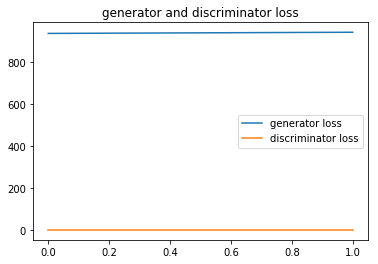

In [7]:
import os
import pandas as pd
# from gan import GAN
import random
import tensorflow as tf

random.seed(2019)
class TrainGan:

    def __init__(self, num_historical_days, batch_size=64):
        self.batch_size = batch_size
        self.data = []
#         files = [os.path.join('./stock_data', f) for f in os.listdir('./stock_data')]

        # Google Drive Method
        files = [f"{googlepath}stock_data/{f}" for f in os.listdir(f"{googlepath}stock_data")]
#         print(files)
      
        for file in files:
            print(file)
            #Read in file -- note that parse_dates will be need later
            df = pd.read_csv(file, index_col='timestamp', parse_dates=True)
            df = df[['open','high','low','close','volume']]
            # #Create new index with missing days

            #Normilize using a of size num_historical_days
            df = ((df -
            df.rolling(num_historical_days).min().shift(-num_historical_days+1))
            /(df.rolling(num_historical_days).max().shift(-num_historical_days+1)
            -df.rolling(num_historical_days).min().shift(-num_historical_days+1)))
            
            #Drop the last 10 day that we don't have data for
            df = df.dropna()
            #Hold out the last year of trading for testing
            test_df = df[100:255]
            #Padding to keep labels from bleeding
            df = df[300:]
            

            for i in range(num_historical_days, len(df), num_historical_days):
                self.data.append(df.values[i-num_historical_days:i])

        self.gan = GAN(num_features=5, num_historical_days=num_historical_days,
                        generator_input_size=200)

    def random_batch(self, batch_size=128):
        batch = []
        while True:
            batch.append(random.choice(self.data))
            if (len(batch) == batch_size):
                yield batch
                batch = []

    def train(self, print_steps=1000, display_data=1000, save_steps=SAVE_STEPS_AMOUNT):
        if not os.path.exists(f'{googlepath}models'):
            os.makedirs(f'{googlepath}models')
        sess = tf.Session()
        
        G_loss = 0
        D_loss = 0
        G_l2_loss = 0
        D_l2_loss = 0
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        currentStep = "0"
        
        g_loss_array = []
        d_loss_array = []
        
        if os.path.exists(f'{googlepath}models/checkpoint'):
                with open(f'{googlepath}models/checkpoint', 'rb') as f:
                    model_name = next(f).split('"'.encode())[1]
                filename = "{}models/{}".format(googlepath, model_name.decode())
                currentStep = filename.split("-")[1]
                new_saver = tf.train.import_meta_graph('{}.meta'.format(filename))
                new_saver.restore(sess, "{}".format(filename))

        for i, X in enumerate(self.random_batch(self.batch_size)):

            
            
            
            if i % 1 == 0:
                _, D_loss_curr, D_l2_loss_curr = sess.run([self.gan.D_solver, self.gan.D_loss, self.gan.D_l2_loss], feed_dict=
                        {self.gan.X:X, self.gan.Z:self.gan.sample_Z(self.batch_size, 200)})
                D_loss += D_loss_curr
                D_l2_loss += D_l2_loss_curr
            if i % 1 == 0:
                _, G_loss_curr, G_l2_loss_curr = sess.run([self.gan.G_solver, self.gan.G_loss, self.gan.G_l2_loss],
                        feed_dict={self.gan.Z:self.gan.sample_Z(self.batch_size, 200)})
                G_loss += G_loss_curr
                G_l2_loss += G_l2_loss_curr
                
            g_loss_array.append(G_loss_curr - G_l2_loss)
            d_loss_array.append(D_loss_curr - D_l2_loss)
            
            
            if (i) % print_steps == 0:
                print('Step={} D_loss={}, G_loss={}'.format(i + int(currentStep), D_loss/print_steps - D_l2_loss/print_steps, G_loss/print_steps - G_l2_loss/print_steps))
                #print('D_l2_loss = {} G_l2_loss={}'.format(D_l2_loss/print_steps, G_l2_loss/print_steps))
                G_loss = 0
                D_loss = 0
                G_l2_loss = 0
                D_l2_loss = 0
            if (i) % save_steps == 0:
                saver.save(sess, f'{googlepath}/models/gan.ckpt', i + int(currentStep))
            
            # end training at training_amount epochs
            if ((i + int(currentStep)) > TRAINING_AMOUNT):
                
                print("Reached {} epochs for GAN".format(i + int(currentStep)))
                sess.close()
                
                axisX = np.arange(0,len(g_loss_array),1)
                plt.plot(axisX, g_loss_array, label='generator loss')
                plt.plot(axisX, d_loss_array, label='discriminator loss')
                plt.legend()
                plt.title('generator and discriminator loss')
                plt.show()
                
                break

            if (i+1) % display_data == 0:
                print('Generated Data')
                print(sess.run(self.gan.gen_data, feed_dict={self.gan.Z:self.gan.sample_Z(1, 200)}))
                print('Real Data')
                print(X[0])


# if __name__ == '__main__':
tf.reset_default_graph()
gan = TrainGan(HISTORICAL_DAYS_AMOUNT, 128)
gan.train()



# Initializing the CNN

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

SEED = 2019
tf.set_random_seed(SEED)
class CNN():

    def __init__(self, num_features, num_historical_days, is_train=True):
      
        self.X = tf.placeholder(tf.float32, shape=[None, num_historical_days, num_features])
        X = tf.reshape(self.X, [-1, num_historical_days, 1, num_features])
        self.Y = tf.placeholder(tf.int32, shape=[None, 2])
        self.keep_prob = tf.placeholder(tf.float32, shape=[])

        with tf.variable_scope("cnn"):
            #[filter_height, filter_width, in_channels, out_channels]
            # layer 1 of cnn has 16 filters
            k1 = tf.Variable(tf.truncated_normal([3, 1, num_features, 16],
                stddev=0.1,seed=SEED, dtype=tf.float32))
            b1 = tf.Variable(tf.zeros([16], dtype=tf.float32))
            conv = tf.nn.conv2d(X,k1,strides=[1, 1, 1, 1],padding='SAME')
            relu = tf.nn.relu(tf.nn.bias_add(conv, b1))
            if is_train:
                relu = tf.nn.dropout(relu, keep_prob = self.keep_prob)
            print(relu)


            # layer 2 of cnn has 32 filters
            k2 = tf.Variable(tf.truncated_normal([3, 1, 16, 32],
                stddev=0.1,seed=SEED, dtype=tf.float32))
            b2 = tf.Variable(tf.zeros([32], dtype=tf.float32))
            conv = tf.nn.conv2d(relu, k2,strides=[1, 1, 1, 1],padding='SAME')
            relu = tf.nn.relu(tf.nn.bias_add(conv, b2))
            if is_train:
                relu = tf.nn.dropout(relu, keep_prob = self.keep_prob)
            print(relu)


            # layer 3 of cnn has 64 filters
            k3 = tf.Variable(tf.truncated_normal([3, 1, 32, 64],
                stddev=0.1,seed=SEED, dtype=tf.float32))
            b3 = tf.Variable(tf.zeros([64], dtype=tf.float32))
            conv = tf.nn.conv2d(relu, k3, strides=[1, 1, 1, 1], padding='VALID')
            relu = tf.nn.relu(tf.nn.bias_add(conv, b3))
            if is_train:
                relu = tf.nn.dropout(relu, keep_prob=self.keep_prob)
            print(relu)


            flattened_convolution_size = int(relu.shape[1]) * int(relu.shape[2]) * int(relu.shape[3])
            print(flattened_convolution_size)
            flattened_convolution = features = tf.reshape(relu, [-1, flattened_convolution_size])

            if is_train:
                flattened_convolution =  tf.nn.dropout(flattened_convolution, keep_prob=self.keep_prob)

            W1 = tf.Variable(tf.truncated_normal([18*1*64, 32]))
            b4 = tf.Variable(tf.truncated_normal([32]))
            h1 = tf.nn.relu(tf.matmul(flattened_convolution, W1) + b4)


            W2 = tf.Variable(tf.truncated_normal([32, 2]))
            logits = tf.matmul(h1, W2)

            #self.accuracy = tf.metrics.accuracy(tf.argmax(self.Y, 1), tf.argmax(logits, 1))
            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.Y, 1), tf.argmax(logits, 1)), tf.float32))
            self.confusion_matrix = tf.confusion_matrix(tf.argmax(self.Y, 1), tf.argmax(logits, 1))
            tf.summary.scalar('accuracy', self.accuracy)
            theta_D = [k1, b1, k2, b2, k3, b3, W1, b4, W2]           
            
            # D_prob = tf.nn.sigmoid(D_logit)

        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.Y, logits=logits))
        tf.summary.scalar('loss', self.loss)

        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(self.loss)
        self.summary = tf.summary.merge_all()

## Training the CNN

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
W0712 21:12:36.561016 140492120618880 deprecation.py:323] From <ipython-input-8-47c6ecefe06d>:75: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Tensor("cnn/Relu:0", shape=(?, 20, 1, 16), dtype=float32)
Tensor("cnn/Relu_1:0", shape=(?, 20, 1, 32), dtype=float32)
Tensor("cnn/Relu_2:0", shape=(?, 18, 1, 64), dtype=float32)
1152
drive/My Drive/Colab Notebooks/stock_data/ACN.csv
drive/My Drive/Colab Notebooks/stock_data/ATVI.csv
drive/My Drive/Colab Notebooks/stock_data/ADBE.csv
drive/My Drive/Colab Notebooks/stock_data/AMD.csv
drive/My Drive/Colab Notebooks/stock_data/AKAM.csv
drive/My Drive/Colab Notebooks/stock_data/ADS.csv
drive/My Drive/Colab Notebooks/stock_data/GOOGL.csv
drive/My Drive/Colab Notebooks/stock_data/GOOG.csv
drive/My Drive/Colab Notebooks/stock_data/APH.csv
drive/My Drive/Colab Notebooks/stock_data/ADI.csv
drive/My Drive/Colab Notebooks/stock_data/ANSS.csv
drive/My Drive/Colab Notebooks/stock_data/AAPL.csv
drive/My Drive/Colab Notebooks/stock_data/AMAT.csv
drive/My Drive/Colab Notebooks/stock_data/ADSK.csv
drive/My Drive/Colab Notebooks/stock_data/ADP.csv
drive/My Drive/Colab Notebooks/stock_data/AVGO.csv
drive/

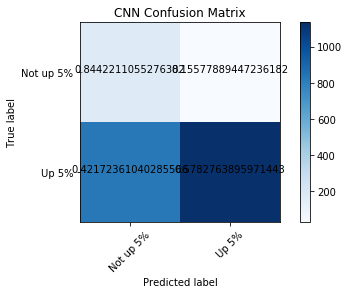

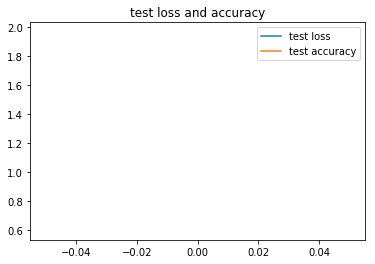

In [9]:
import os
import pandas as pd
# from cnn import CNN
import random
import tensorflow as tf
import xgboost as xgb
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
# from plot_confusion_matrix import plot_confusion_matrix

random.seed(2019)

class TrainCNN:

    def __init__(self, num_historical_days, days=10, pct_change=0):
        self.data = []
        self.labels = []
        self.test_data = []
        self.test_labels = []
        self.cnn = CNN(num_features=5, num_historical_days=num_historical_days, is_train=False)
#         files = [os.path.join('./stock_data', f) for f in os.listdir('./stock_data')]

        # Google Drive Method
        files = [f"{googlepath}stock_data/{f}" for f in os.listdir(f"{googlepath}stock_data")]
#         print(files)
    
    
        for file in files:
            print(file)
            df = pd.read_csv(file, index_col='timestamp', parse_dates=True)
            df = df[['open','high','low','close','volume']]
            # data for new column labels that will use the pct_change of the closing data.
            # pct_change measure change between current and prior element. Map these into a 1x2
            # array to show if the pct_change > (our desired threshold) or less than.
            labels = df.close.pct_change(days).map(lambda x: [int(x > pct_change/100.0), int(x <= pct_change/100.0)])
            
            # rolling normalization. (df - df.mean) / (df.max - df.min)
            df = ((df -
            df.rolling(num_historical_days).mean().shift(-num_historical_days+1))
            /(df.rolling(num_historical_days).max().shift(-num_historical_days+1)
            -df.rolling(num_historical_days).min().shift(-num_historical_days+1)))
            df['labels'] = labels

            # doing pct_change will give some rows (like first row) a NaN value. Drop that.
            df = df.dropna()

            # Do the testing data split
            test_df = df[100:150]
            df = df[:-200]

            # get the predictors of the dataframe
            data = df[['open','high','low','close','volume']].values

            # the response value
            labels = df['labels'].values

            # start at num_historical_days and iterate the full length of the training
            # data at intervals of num_historical_days
            for i in range(num_historical_days, len(df), num_historical_days):
                # split the df into arrays of length num_historical_days and append
                # to data, i.e. array of df[curr - num_days : curr] -> a batch of values
                self.data.append(data[i-num_historical_days:i])

                # appending if price went up or down in curr day of "i" we are looking
                # at
                self.labels.append(labels[i-1])
            
            # do same for test data
            data = test_df[['open','high','low','close','volume']].values
            labels = test_df['labels'].values
            for i in range(num_historical_days, len(test_df), 1):
                self.test_data.append(data[i-num_historical_days:i])
                self.test_labels.append(labels[i-1])

    # a function to get a random_batch of data.
    def random_batch(self, batch_size=128):
        batch = []
        labels = []
        # zip concatenates each array index of both arrays together
        data = list(zip(self.data, self.labels))
        i = 0
        while True:
            i+= 1
            while True:
                # pick a random array, i.e. range of days, from data
                d = random.choice(data)
                # balance the data with equal number of positive pct_change
                # and negative pct_change
                if(d[1][0]== int(i%2)):
                    break
            batch.append(d[0])  # append the range of days we got to batch
            labels.append(d[1])  # append the label of that range of data we got
            if (len(batch) == batch_size):
                yield batch, labels
                batch = []
                labels = []

    def train(self, print_steps=500, display_steps=5000, save_steps=SAVE_STEPS_AMOUNT, batch_size=128, keep_prob=0.6):
        if not os.path.exists(f'{googlepath}cnn_models'):
            os.makedirs(f'{googlepath}cnn_models')
        if not os.path.exists(f'{googlepath}logs'):
            os.makedirs(f'{googlepath}logs')
        if os.path.exists(f'{googlepath}logs/train'):
            for file in [os.path.join(f'{googlepath}logs/train/', f) for f in os.listdir(f'{googlepath}logs/train/')]:
                os.remove(file)
        if os.path.exists(f'{googlepath}logs/test'):
            for file in [os.path.join(f'{googlepath}logs/test/', f) for f in os.listdir(f'{googlepath}logs/test')]:
                os.remove(file)

        sess = tf.Session()
        loss = 0
        l2_loss = 0
        accuracy = 0
        saver = tf.train.Saver()
        train_writer = tf.summary.FileWriter(f'{googlepath}/logs/train')
        test_writer = tf.summary.FileWriter(f'{googlepath}/logs/test')
        sess.run(tf.global_variables_initializer())
        
        test_loss_array = []
        test_accuracy_array = []
        currentStep = "0"
        
        if os.path.exists(f'{googlepath}cnn_models/checkpoint'):
                with open(f'{googlepath}cnn_models/checkpoint', 'rb') as f:
                    model_name = next(f).split('"'.encode())[1]
                filename = "{}cnn_models/{}".format(googlepath, model_name.decode())
                currentStep = filename.split("-")[1]
                new_saver = tf.train.import_meta_graph('{}.meta'.format(filename))
                new_saver.restore(sess, "{}".format(filename))

        for i, [X, y] in enumerate(self.random_batch(batch_size)):

          
            _, loss_curr, accuracy_curr = sess.run([self.cnn.optimizer, self.cnn.loss, self.cnn.accuracy], feed_dict=
                    {self.cnn.X:X, self.cnn.Y:y, self.cnn.keep_prob:keep_prob})
            loss += loss_curr
            accuracy += accuracy_curr
            if (i) % print_steps == 0:
                print('Step={} loss={}, accuracy={}'.format(i + int(currentStep), loss/print_steps, accuracy/print_steps))
                loss = 0
                l2_loss = 0
                accuracy = 0
                test_loss, test_accuracy, confusion_matrix = sess.run([self.cnn.loss, self.cnn.accuracy, self.cnn.confusion_matrix], feed_dict={self.cnn.X:self.test_data, self.cnn.Y:self.test_labels, self.cnn.keep_prob:1})
                test_loss_array.append(test_loss)
                test_accuracy_array.append(test_accuracy)
                print("Test loss = {}, Test accuracy = {}".format(test_loss, test_accuracy))
            if (i+1) % save_steps == 0:
                saver.save(sess,  f'{googlepath}cnn_models/cnn.ckpt', i)

            if (i+1) % display_steps == 0:
                summary = sess.run(self.cnn.summary, feed_dict=
                    {self.cnn.X:X, self.cnn.Y:y, self.cnn.keep_prob:keep_prob})
                train_writer.add_summary(summary, i)
                summary = sess.run(self.cnn.summary, feed_dict={
                    self.cnn.X:self.test_data, self.cnn.Y:self.test_labels, self.cnn.keep_prob:1})
                test_writer.add_summary(summary, i)
            
            # end training at training_amount epochs
            if (i + int(currentStep)) > TRAINING_AMOUNT:
                print("Reached {} epochs for CNN".format(i + int(currentStep)))
                sess.close()
                print(confusion_matrix)
                plot_confusion_matrix(confusion_matrix, ['Not up 5%', 'Up 5%'], normalize=True, title="CNN Confusion Matrix")
                
                axisX = np.arange(0,len(test_loss_array),1)
                plt.plot(axisX, test_loss_array, label='test loss')
                plt.plot(axisX, test_accuracy_array, label='test accuracy')
                plt.legend()
                plt.title('test loss and accuracy')
                plt.show()

                break


# if __name__ == '__main__':
tf.reset_default_graph()
cnn = TrainCNN(num_historical_days=HISTORICAL_DAYS_AMOUNT, days=DAYS_AHEAD, pct_change=10)
cnn.train()
# print(confusion_matrix)




# Train XGB Boost

Tensor("Relu:0", shape=(?, 20, 1, 32), dtype=float32)
Tensor("Relu_1:0", shape=(?, 20, 1, 64), dtype=float32)
Tensor("Relu_2:0", shape=(?, 18, 1, 128), dtype=float32)
2304
Tensor("Relu_4:0", shape=(?, 20, 1, 32), dtype=float32)
Tensor("Relu_5:0", shape=(?, 20, 1, 64), dtype=float32)
Tensor("Relu_6:0", shape=(?, 18, 1, 128), dtype=float32)
2304
drive/My Drive/Colab Notebooks/stock_data/ACN.csv
drive/My Drive/Colab Notebooks/stock_data/ATVI.csv
drive/My Drive/Colab Notebooks/stock_data/ADBE.csv
drive/My Drive/Colab Notebooks/stock_data/AMD.csv
drive/My Drive/Colab Notebooks/stock_data/AKAM.csv
drive/My Drive/Colab Notebooks/stock_data/ADS.csv
drive/My Drive/Colab Notebooks/stock_data/GOOGL.csv
drive/My Drive/Colab Notebooks/stock_data/GOOG.csv
drive/My Drive/Colab Notebooks/stock_data/APH.csv
drive/My Drive/Colab Notebooks/stock_data/ADI.csv
drive/My Drive/Colab Notebooks/stock_data/ANSS.csv
drive/My Drive/Colab Notebooks/stock_data/AAPL.csv
drive/My Drive/Colab Notebooks/stock_data/AMAT

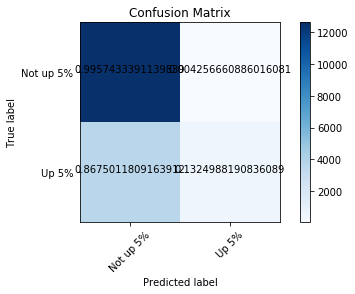

In [10]:
import os
import pandas as pd
# from gan import GAN
import random
import tensorflow as tf
import xgboost as xgb
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
# from plot_confusion_matrix import plot_confusion_matrix

# os.environ["CUDA_VISIBLE_DEVICES"]=""

class TrainXGBBoost:

    def __init__(self, num_historical_days, days=10, pct_change=0):
        self.data = []
        self.labels = []
        self.test_data = []
        self.test_labels = []
        
        assert os.path.exists(f'{googlepath}models/checkpoint')
        gan = GAN(num_features=5, num_historical_days=num_historical_days,
                        generator_input_size=200, is_train=False)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            saver = tf.train.Saver()
            if os.path.exists(f'{googlepath}models/checkpoint'):
                    
                    with open(f'{googlepath}models/checkpoint', 'rb') as f:
                        model_name = next(f).split('"'.encode())[1]
                    filename = "{}models/{}".format(googlepath, model_name.decode())
                    currentStep = filename.split("-")[1]
                    new_saver = tf.train.import_meta_graph('{}.meta'.format(filename))
                    new_saver.restore(sess, "{}".format(filename))
            files = [os.path.join(f'{googlepath}stock_data', f) for f in os.listdir(f'{googlepath}/stock_data')]
            for file in files:
                print(file)
                #Read in file -- note that parse_dates will be need later
                df = pd.read_csv(file, index_col='timestamp', parse_dates=True)
                df = df[['open','high','low','close','volume']]
                # #Create new index with missing days
                # idx = pd.date_range(df.index[-1], df.index[0])
                # #Reindex and fill the missing day with the value from the day before
                # df = df.reindex(idx, method='bfill').sort_index(ascending=False)
                #Normilize using a of size num_historical_days
                labels = df.close.pct_change(days).map(lambda x: int(x > pct_change/100.0))
                df = ((df -
                df.rolling(num_historical_days).mean().shift(-num_historical_days))
                /(df.rolling(num_historical_days).max().shift(-num_historical_days)
                -df.rolling(num_historical_days).min().shift(-num_historical_days)))
                df['labels'] = labels
                #Drop the last 10 day that we don't have data for
                df = df.dropna()
                #Hold out the last year of trading for testing
                test_df = df[:255]
                #Padding to keep labels from bleeding
                df = df[300:]

                data = df[['open','high','low','close','volume']].values
                labels = df['labels'].values
                for i in range(num_historical_days, len(df), num_historical_days):
                    features = sess.run(gan.features, feed_dict={gan.X:[data[i-num_historical_days:i]]})
                    self.data.append(features[0])
#                     print(features[0])
                    self.labels.append(labels[i-1])
                data = test_df[['open','high','low','close','volume']].values
                labels = test_df['labels'].values
                for i in range(num_historical_days, len(test_df), 1):
                    features = sess.run(gan.features, feed_dict={gan.X:[data[i-num_historical_days:i]]})
                    self.test_data.append(features[0])
                    self.test_labels.append(labels[i-1])

    # a function to get a random_batch of data.
    def random_batch(self, batch_size=128):
        batch = []
        labels = []
        # zip concatenates each array index of both arrays together
        data = list(zip(self.data, self.labels))
        i = 0
        while True:
            i+= 1
            while True:
                # pick a random array, i.e. range of days, from data
                d = random.choice(data)
                # balance the data with equal number of positive pct_change
                # and negative pct_change
                if(d[1][0]== int(i%2)):
                    break
            batch.append(d[0])  # append the range of days we got to batch
            labels.append(d[1])  # append the label of that range of data we got
            if (len(batch) == batch_size):
                yield batch, labels
                batch = []
                labels = []

    def train(self):
        params = {}
        params['objective'] = 'multi:softprob'
        params['eta'] = 0.01
        params['num_class'] = 2
        params['max_depth'] = 20
        params['subsample'] = 0.05
        params['colsample_bytree'] = 0.05
        params['eval_metric'] = 'mlogloss'


        train = xgb.DMatrix(self.data, self.labels)
        test = xgb.DMatrix(self.test_data, self.test_labels)

        watchlist = [(train, 'train'), (test, 'test')]
        clf = xgb.train(params, train, 100, evals=watchlist, early_stopping_rounds=100)
        joblib.dump(clf, f'{googlepath}models/clf.pkl')
        # cm = confusion_matrix(self.test_labels, map(lambda x: int(x[1] > .5), clf.predict(test)))
        cm = confusion_matrix(self.test_labels, list(map(lambda x: int(x[1] > .5), clf.predict(test))))
        print(cm)
        plot_confusion_matrix(cm, ['Not up 5%', 'Up 5%'], normalize=True, title="Confusion Matrix")

tf.reset_default_graph()
boost_model = TrainXGBBoost(num_historical_days=HISTORICAL_DAYS_AMOUNT, days=DAYS_AHEAD, pct_change=PCT_CHANGE_AMOUNT)
boost_model.train()


## Change the names of the files in the deployed_model folder

Directions: Run after training and placing the GAN checkpoints you desire into the deployed_models folder. Then thisd code will rename all of them so that they run for the "Get the Predictions" section.

In [11]:
import os

# Below Code Gets Rid of Copy Of when making a copy of the models.
for filename in os.listdir(f'{googlepath}deployed_model/'):
    split = filename.split(" ")
    if len(split) == 3:
        os.rename(f'{googlepath}deployed_model/{filename}', f'{googlepath}deployed_model/{split[2]}')
    else:
        print("Nothing to rename.")

# Below Code Gets Rid of Checkpoint Number in Name
for filename in os.listdir(f'{googlepath}deployed_model/'):
    split = filename.split(".")
    if len(split) == 3:
        prefix, _, suffix = split
        new_name = prefix + "." + suffix
        os.rename(f'{googlepath}deployed_model/{filename}', f'{googlepath}deployed_model/{new_name}')
    elif filename == "clf.pkl":
        os.rename(f'{googlepath}deployed_model/{filename}', f'{googlepath}deployed_model/xgb')
    else:
        print("Nothing to rename.")



Nothing to rename.
Nothing to rename.
Nothing to rename.
Nothing to rename.
Nothing to rename.
Nothing to rename.


# Get the Predictions

In [12]:
import os
import pandas as pd
# from gan import GAN
import random
import tensorflow as tf
import xgboost as xgb
from sklearn.externals import joblib


# os.environ["CUDA_VISIBLE_DEVICES"]=""

class Predict:

    def __init__(self, num_historical_days=20, days=10, pct_change=0, 
                 gan_model=f'{googlepath}deployed_model/gan.txt', 
                 cnn_model=f'{googlepath}deployed_model/cnn', 
                 xgb_model=f'{googlepath}deployed_model/xgb'):
        self.data = []
        self.num_historical_days = num_historical_days
        self.gan_model = gan_model
        self.cnn_model = cnn_model
        self.xgb_model = xgb_model
        # assert os.path.exists(gan_model)
        # assert os.path.exists(cnn_modle)
        # assert os.path.exists(xgb_model)

        files = [os.path.join(f'{googlepath}stock_data', f) for f in os.listdir(f'{googlepath}stock_data')]
        for file in files:
            print(file)
            df = pd.read_csv(file, index_col='timestamp', parse_dates=True)
            df = df.sort_index(ascending=False)
            df = df[['open', 'high', 'low', 'close', 'volume']]
            df = ((df -
                  df.rolling(num_historical_days).mean().shift(-num_historical_days)) /
                  (df.rolling(num_historical_days).max().shift(-num_historical_days) -
                  df.rolling(num_historical_days).min().shift(-num_historical_days)))
            df = df.dropna()

            """
            file.split --> is the symbol of the current file. Append a tuple of
            that symbol and the dataframe index[0] which is the timestamp, and
            thirdly append the data for 200 to 200 + num_historical_days values
            (open, high, low, close, volume). For each symbol we have, we are
            predicting based on the df[200:200+num_historical_days].values...
            """
            self.data.append((file.split('/')[-1], df.index[0], df[200:200+num_historical_days].values))
            
#         print("Data: ", self.data)


    def gan_predict(self):
        # clears the default graph stack and resets the global default graph.

        tf.reset_default_graph() 
        gan = GAN(num_features=5, num_historical_days=self.num_historical_days,
                  generator_input_size=200, is_train=False)
        # A class for running Tensorflow operations. A session object
        # encapsulates the environment in which Operation objects are executed,
        # and Tensor objects are evaluated. A session may own resources, such as
        # tf.Variable, tf.QueueBase and tf.ReaderBase. It is important to
        # release these resources when they are no longer required. Invoke
        # tf.Session.close method on the session or use the session as a context
        # manager. 
        # with tf.Session() as sess:
        #   sess.run(...)
        # or
        # sess = tf.Session()
        # sess.run(...)
        # sess.close()     
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            saver = tf.train.Saver()
          #  saver.restore(sess, self.gan_model)
            # Reconstruct a Python object from a file persisted with joblib.dump
            clf = joblib.load(self.xgb_model)
            for sym, date, data in self.data:
                # run takes in feed_dict=None, session=None. A feed_dict is a
                # dictionary that maps Tensor objects to feed values. In this
                # case, I believe we are doing run( fetches, feed_dict=None...)
                # case where the fetches is gan.features and the feed_dict
                # points to the gan.X dictionary which points to data. The
                # fetches argument may be a single graph element, or an
                # arbitrarily nested list, tuple, namedtuple, dict, or
                # OrderedDict containing graph elements at its leaves.
#                 print("data: ", data)
#                 print("data length: ", len(data))
#                 print("gan features: ", gan.features)
                features = sess.run(gan.features, feed_dict={gan.X:[data]})
                # Value returned by run() has the same shape as the fetches
                # argument, where the leaves are replaced by the corresponding
                # values returned by TensorFlow.  
                
                # xgb.DMatrix, construct one from either a dense matrix, a
                # sparse matrix, or a local file. Supported input file formats
                # are either a libsvm text file or a binary file that was
                # created previously by xgb.DMatrix.save. Internal data
                # structure that is used by XGBoost which is optimized for both
                # memory efficiency and training speed.
                features = xgb.DMatrix(features)
                

                # The clf predict is the xgb classifier that is used on the gan
                # features (the flattened last layer of the convolutional neural
                # network, that is the discriminator). As far as I can tell, we
                # are using the GAN on the past 20 days to come up with some
                # features. Then these features are plugged into the XGBoost
                # Classifier. Then the XGBoost Classifier makes a prediction for
                # the stock (going Up or Down).
                print('{} {} {}'.format(str(date).split(' ')[0], sym, clf.predict(features)[0][1] > 0.5))


# if __name__ == '__main__':
p = Predict(num_historical_days=HISTORICAL_DAYS_AMOUNT, days=DAYS_AHEAD, pct_change=PCT_CHANGE_AMOUNT)
p.gan_predict()


drive/My Drive/Colab Notebooks/stock_data/ACN.csv
drive/My Drive/Colab Notebooks/stock_data/ATVI.csv
drive/My Drive/Colab Notebooks/stock_data/ADBE.csv
drive/My Drive/Colab Notebooks/stock_data/AMD.csv
drive/My Drive/Colab Notebooks/stock_data/AKAM.csv
drive/My Drive/Colab Notebooks/stock_data/ADS.csv
drive/My Drive/Colab Notebooks/stock_data/GOOGL.csv
drive/My Drive/Colab Notebooks/stock_data/GOOG.csv
drive/My Drive/Colab Notebooks/stock_data/APH.csv
drive/My Drive/Colab Notebooks/stock_data/ADI.csv
drive/My Drive/Colab Notebooks/stock_data/ANSS.csv
drive/My Drive/Colab Notebooks/stock_data/AAPL.csv
drive/My Drive/Colab Notebooks/stock_data/AMAT.csv
drive/My Drive/Colab Notebooks/stock_data/ADSK.csv
drive/My Drive/Colab Notebooks/stock_data/ADP.csv
drive/My Drive/Colab Notebooks/stock_data/AVGO.csv
drive/My Drive/Colab Notebooks/stock_data/CA.csv
drive/My Drive/Colab Notebooks/stock_data/CDNS.csv
drive/My Drive/Colab Notebooks/stock_data/CSCO.csv
drive/My Drive/Colab Notebooks/stock_d